# 06 Schätzen & Konfidenzintervalle
----------------------------------------------------------------------

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent          # eine Ebene über notebooks/
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq


PATH = "../data/Taxi_final_1M_clean.csv"
df = pd.read_csv(PATH)

print(80*"=")
print(f"Datensatz geladen: {df.shape[0]:,} Zeilen, {df.shape[1]} Spalten")
print(80*"-")
print("Erste Zeilen:", "\n", df.head(3))
print(80*"-")
print(df.describe())
print(80*"-")
print(df.info())
print(80*"=")

Projekt-Root hinzugefügt: /home/benjamin/HSG/Statistik/Project
Datensatz geladen: 967,493 Zeilen, 17 Spalten
--------------------------------------------------------------------------------
Erste Zeilen: 
   tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2023-02-06 18:31:28   2023-02-06 18:41:28              1.0            2.8   
1  2023-01-24 12:53:51   2023-01-24 13:06:09              5.0            2.3   
2  2023-02-04 22:58:49   2023-02-04 23:03:11              2.0            1.1   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  tip_amount  \
0           162           113             1         11.4    2.5         2.0   
1           142            48             2         12.1    0.0         0.0   
2           107           107             1          5.8    3.5         1.2   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0           0.0                    1.0          19.9                   2.5   


## 1. Punktschätzung, Standardfehler und Konfidenzintervall

Die roten Linien markieren die 5% der zu erwartenden Fehlerfälle, bei einem 95%-Konfidenzintervall.

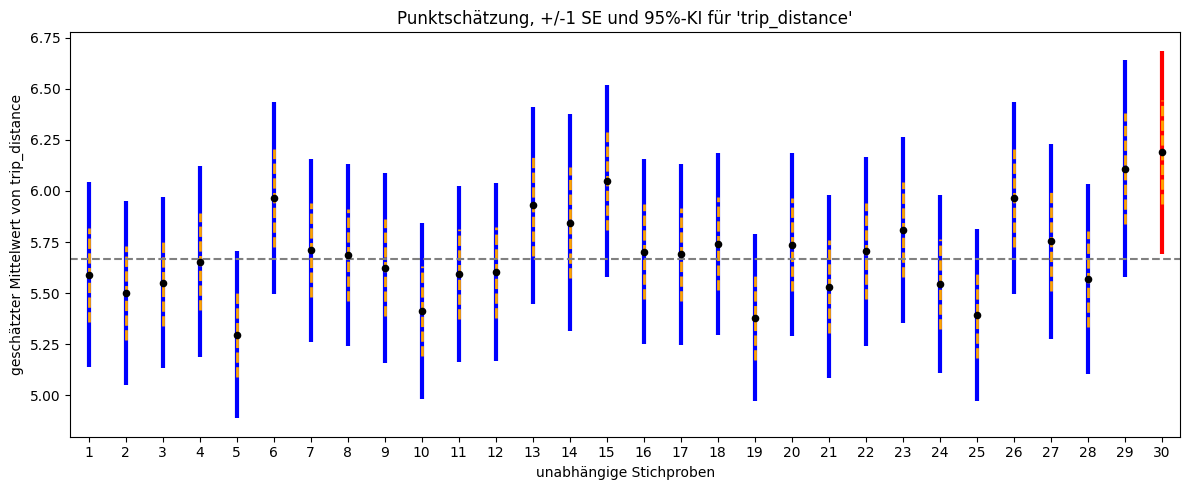

In [2]:
x = df["trip_distance"].to_numpy(dtype=float)
x = x[np.isfinite(x) & (x > 0)]
mu_true = x.mean()

# Parameter
S = 30          # Anzahl Stichproben
n = 1000        # Größe je Stichprobe
z = 1.96        # Etwa 95% der Daten liegen innerhalb von +/- 1.96 Standardabweichungen um den Mittelwert (-> laut Slide 95% Konfidenzintervall)

rng = np.random.default_rng(0)

means, standard_errors, lower_bounds, higher_bounds = [], [], [], []
for _ in range(S):
    stichprobe = rng.choice(x, size=n, replace=False)
    mean = stichprobe.mean()
    se = stichprobe.std(ddof=1) / np.sqrt(n)
    means.append(mean)
    standard_errors.append(se)
    lower_bounds.append(mean - z * se)
    higher_bounds.append(mean + z * se)

means = np.array(means)
standard_erros = np.array(standard_errors)
lower_bounds = np.array(lower_bounds)
higher_bounds = np.array(higher_bounds)

# Plot - optimized with AI
plt.figure(figsize=(12,5))
idx = np.arange(S)
for i in range(S):
    c = "blue" if (lower_bounds[i] <= mu_true <= higher_bounds[i]) else "red"
    plt.vlines(i, lower_bounds[i], higher_bounds[i], color=c, linewidth=3)           # 95%
    plt.vlines(i, means[i] - standard_erros[i], means[i] + standard_erros[i],        # +/- 1 SE
               color="orange", linestyles="--", linewidth=2)
plt.scatter(idx, means, color="black", s=20, zorder=3)            # Punkt-Schätzung
plt.hlines(mu_true, -0.5, S-0.5, colors="gray", linestyles="--")  # wahrer Mittelwert

plt.xticks(idx, idx+1); plt.xlim(-0.5, S-0.5)
plt.xlabel("unabhängige Stichproben")
plt.ylabel("geschätzter Mittelwert von trip_distance")
plt.title("Punktschätzung, +/-1 SE und 95%-KI für 'trip_distance'")
plt.tight_layout()
plt.show()

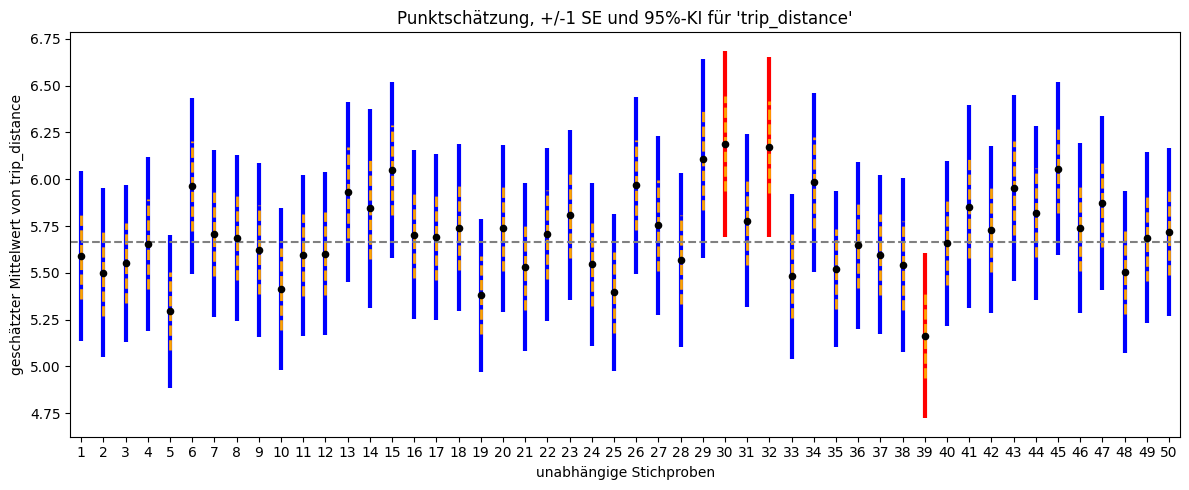

In [3]:
x = df["trip_distance"].to_numpy(dtype=float)
x = x[np.isfinite(x) & (x > 0)]
mu_true = x.mean()

# Parameter
S = 50          # Anzahl Stichproben
n = 1000        # Größe je Stichprobe
z = 1.96        # Etwa 95% der Daten liegen innerhalb von +/- 1.96 Standardabweichungen um den Mittelwert (-> laut Slide 95% Konfidenzintervall)

rng = np.random.default_rng(0)

means, standard_errors, lower_bounds, higher_bounds = [], [], [], []
for _ in range(S):
    stichprobe = rng.choice(x, size=n, replace=False)
    mean = stichprobe.mean()
    se = stichprobe.std(ddof=1) / np.sqrt(n)
    means.append(mean)
    standard_errors.append(se)
    lower_bounds.append(mean - z * se)
    higher_bounds.append(mean + z * se)

means = np.array(means)
standard_erros = np.array(standard_errors)
lower_bounds = np.array(lower_bounds)
higher_bounds = np.array(higher_bounds)

# Plot - optimized with AI
plt.figure(figsize=(12,5))
idx = np.arange(S)
for i in range(S):
    c = "blue" if (lower_bounds[i] <= mu_true <= higher_bounds[i]) else "red"
    plt.vlines(i, lower_bounds[i], higher_bounds[i], color=c, linewidth=3)           # 95%
    plt.vlines(i, means[i] - standard_erros[i], means[i] + standard_erros[i],        # +/- 1 SE
               color="orange", linestyles="--", linewidth=2)
plt.scatter(idx, means, color="black", s=20, zorder=3)            # Punkt-Schätzung
plt.hlines(mu_true, -0.5, S-0.5, colors="gray", linestyles="--")  # wahrer Mittelwert

plt.xticks(idx, idx+1); plt.xlim(-0.5, S-0.5)
plt.xlabel("unabhängige Stichproben")
plt.ylabel("geschätzter Mittelwert von trip_distance")
plt.title("Punktschätzung, +/-1 SE und 95%-KI für 'trip_distance'")
plt.tight_layout()
plt.show()

---

## 2. Bootstrap

Hier können wir den average Fahrweg (-> trip_distance) aller Taxis im Jahre 2023 betrachten. Dieser Mittelwert ist nur eine Stichprobenschätzung des korrekten Mittelwertes.
In dem Histogramm sieht man die empirische Verteilung der Mittelwerte. Die y-achse gibt dabei die Häufigkeit an, wie oft dieser Wert in 5000 Bootstrap-Stichproben vorkam.

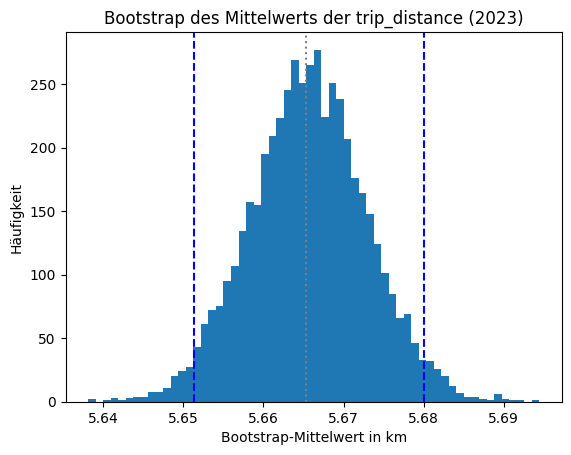

Mittelwert: 5.67 km
95% Konfidenzintervall: [5.65, 5.68] km


In [4]:
df["tpep_pickup_datetime"] = df["tpep_pickup_datetime"].astype("datetime64[ns]")
df["tpep_dropoff_datetime"] = df["tpep_dropoff_datetime"].astype("datetime64[ns]")

x = df.loc[
    (df.tpep_pickup_datetime.dt.year == 2023), 
    "trip_distance"
].to_numpy(float)

x = x[np.isfinite(x) & (x > 0)]

B = 5000
rng = np.random.default_rng(0)
bootstrap_estimates = np.array([rng.choice(x, size=x.size, replace=True).mean() for _ in range(B)])

ci_lo, ci_hi = np.percentile(bootstrap_estimates, [2.5, 97.5])
mu_true = x.mean()

plt.hist(bootstrap_estimates, bins=60)
plt.axvline(ci_lo, ls="--", color="blue")
plt.axvline(ci_hi, ls="--", color="blue")
plt.axvline(mu_true, ls=":", color="gray")
plt.title("Bootstrap des Mittelwerts der trip_distance (2023)")
plt.xlabel("Bootstrap-Mittelwert in km")
plt.ylabel("Häufigkeit")
plt.show()

print(f"Mittelwert: {mu_true:.2f} km")
print(f"95% Konfidenzintervall: [{ci_lo:.2f}, {ci_hi:.2f}] km")

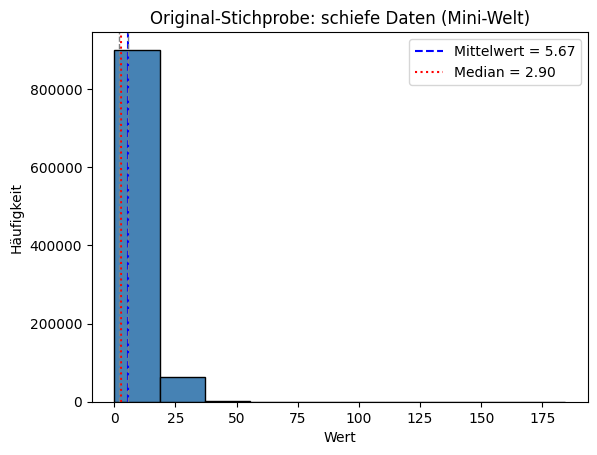

In [5]:
plt.hist(x, bins=10, color="steelblue", edgecolor="black")
plt.axvline(x.mean(), color="blue", ls="--", label=f"Mittelwert = {x.mean():.2f}")
plt.axvline(np.median(x), color="red", ls=":", label=f"Median = {np.median(x):.2f}")
plt.axvline(np.percentile(x, 25), color="gray", ls="--", lw=1)
plt.axvline(np.percentile(x, 75), color="gray", ls="--", lw=1)
plt.title("Original-Stichprobe: schiefe Daten (Mini-Welt)")
plt.xlabel("Wert"); plt.ylabel("Häufigkeit")
plt.legend()
plt.show()

***Vergleich Reale Stichprobe & Bootstrap-Verteilung***

**Originale Stichprobe:**
 - sehr rechtsschief
 - Die rote gestrichelte Linie markiert den Stichprobenmittelwert (Punktschätzung für den tatsächlichen Durchschnitt aller Fahrten im Jahre 2023)

**Bootstrap Verteilung der Mittelwerte**
 - Hier können wir die Verteilung der Mittelwerte sehen, welche wir durch 5000 Bootstrap-Stichproben erhalten haben. Die Stichproben sind mit Zurücklegen aus den Originaldaten implementiert. 
 - Diese Verteilung ist fast symmetrisch und schmal $\rightarrow$ der Mittelwert is also ein stabiler Schätzer, da er nicht extrem zwischen Stichproben schwankt.
 - Die schwarz gestichelten Linien zeigen das 95% Konfidenzintervall.

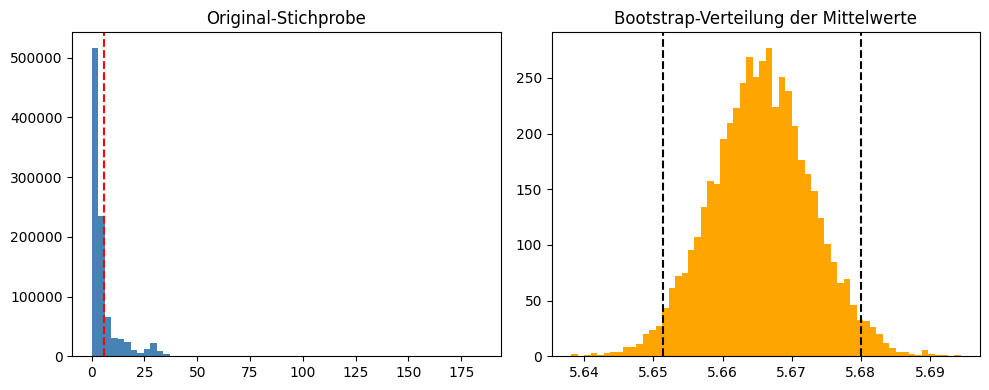

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(x, bins=60, color="steelblue")
ax[0].axvline(x.mean(), color="red", ls="--", label="Stichprobenmittel")
ax[0].set_title("Original-Stichprobe")

ax[1].hist(bootstrap_estimates, bins=60, color="orange")
ax[1].axvline(np.percentile(bootstrap_estimates, 2.5), color="black", ls="--")
ax[1].axvline(np.percentile(bootstrap_estimates, 97.5), color="black", ls="--")
ax[1].set_title("Bootstrap-Verteilung der Mittelwerte")
plt.tight_layout(); plt.show()

## 2. Punktschätzung

- z-Verteilung vs. t-Verteilung
- Bias und Varianz $\rightarrow$ Effizienz
- Bias-Varianz-Trade-off: $MSE = Bias^2 + Varianz$
- MSE-Kurve vs. Komplexität

### Punktschätzung

In [7]:
x = df.loc[df.tpep_pickup_datetime.dt.year == 2023, "trip_distance"].to_numpy(float)
x = x[np.isfinite(x) & (x > 0)]

mean_trip = np.mean(x)
median_trip = np.median(x)
share_short = np.mean(x < 2)
share_long = np.mean(x > 10)

print(f"⌀ Distanz: {mean_trip:.2f} km")
print(f"Median: {median_trip:.2f} km")
print(f"Anteil Kurzfahrten <2km: {share_short:.1%}")
print(f"Anteil Langfahrten >10km: {share_long:.1%}")

⌀ Distanz: 5.67 km
Median: 2.90 km
Anteil Kurzfahrten <2km: 30.4%
Anteil Langfahrten >10km: 14.6%


### Standarfehler (SE)

In [8]:
n = len(x)
std = np.std(x, ddof=1)
se_mean = std / np.sqrt(n)
print(f"Standardfehler des Mittelwerts: {se_mean:.4f}")

Standardfehler des Mittelwerts: 0.0074


### Konfidenzintervall

In [9]:
z = 1.96  # 95% Konfidenzintervall
ci_lo, mean_trip - z * se_mean
ci_hi = mean_trip + z * se_mean
print(f"95% Konfidenzintervall: [{ci_lo:.2f}, {ci_hi:.2f}] km")

95% Konfidenzintervall: [5.65, 5.68] km


### Bootstrap

***Ziel:*** Konfidenzintervall ohne Annahmen über die Verteilung.
Das Bootstrap Konfidenzintervall zeigt uns, dass man auch bei schiefen Daten ein stabiles Intervall erhält.

In [10]:
B = 1000
rng = np.random.default_rng(0)
boot_means = np.array([rng.choice(x, size=50_000, replace=True).mean() for _ in range(B)])
ci_boot = np.percentile(boot_means, [2.5, 97.5])
print(f"Bootstrap-KI: [{ci_boot[0]:.3f}, {ci_boot[1]:.3f}] km")

Bootstrap-KI: [5.605, 5.732] km


### z-Verteilung vs. t-Verteilung

In [11]:
sample = rng.choice(x, size=30, replace=False)
xbar = sample.mean()
s = sample.std(ddof=1)
se = s / np.sqrt(len(sample))
z_ci = [xbar - z * se, xbar + z * se]
t_ci = st.t.interval(0.95, df=len(sample)-1, loc=xbar, scale=se)
print(f"Z-Konfidenzintervall: [{z_ci[0]:.2f}, {z_ci[1]:.2f}]")
print(f"T-Konfidenzintervall: [{t_ci[0]:.2f}, {t_ci[1]:.2f}]")

Z-Konfidenzintervall: [2.30, 4.86]
T-Konfidenzintervall: [2.25, 4.91]


Vergleich zwischen z-Verteilung und t-Verteilung mit Freiheitsgraden von der Slide

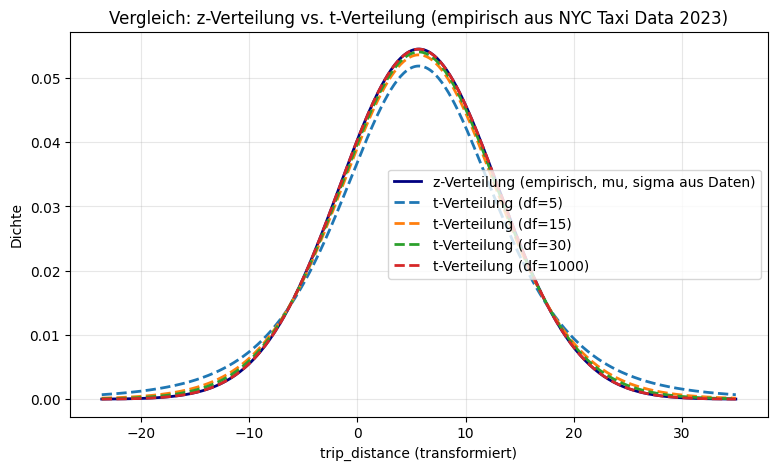

In [12]:
x = df.loc[df["tpep_pickup_datetime"].dt.year == 2023, "trip_distance"].to_numpy(dtype=float)

mu = np.mean(x)
sigma = np.std(x, ddof=1)

dfs = [5, 15, 30, 1000]
x_vals = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 400) # 400 gleichmäßig verteilte Punkte rund um den mittelwert

z_pdf = st.norm.pdf(x_vals, loc=mu, scale=sigma)

t_pdfs = [st.t.pdf((x_vals - mu)/sigma, df=df_) / sigma for df_ in dfs]

plt.figure(figsize=(9,5))
plt.plot(x_vals, z_pdf, color="navy", linewidth=2, label="z-Verteilung (empirisch, mu, sigma aus Daten)")
for t_pdf, df_ in zip(t_pdfs, dfs):
    plt.plot(x_vals, t_pdf, "--", linewidth=2, label=f"t-Verteilung (df={df_})")

plt.title("Vergleich: z-Verteilung vs. t-Verteilung (empirisch aus NYC Taxi Data 2023)")
plt.xlabel("trip_distance (transformiert)")
plt.ylabel("Dichte")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [13]:
n_small = 1000 # hier haben wir eine kleine Stichprobengröße gewählt
means = [rng.choice(x, size=n_small, replace=False).mean() for _ in range(100)] # jeweils 100 Stichproben aus x ohne Zurücklegen ziehen + für jede Stichprobe den Mittelwert berechnen
bias = np.mean(means) - mean_trip # der durchschnittliche Schätzwert über alle Stichproben
var = np.var(means, ddof=1) # Zufällige Schwankung der Schätzungen (-> Streungsfehler auch genannt)
mse = bias ** 2 + var # interessant: ich kenne den mse eher aus dem Machine Learning Bereich (z.B. auch sklearn.metics) und für Modellvorhersagen
print(f"Bias={bias:.3f}")
print(f"Var={var:.3f}")
print(f"MSE={mse:.3f}")

Bias=0.021
Var=0.056
MSE=0.056


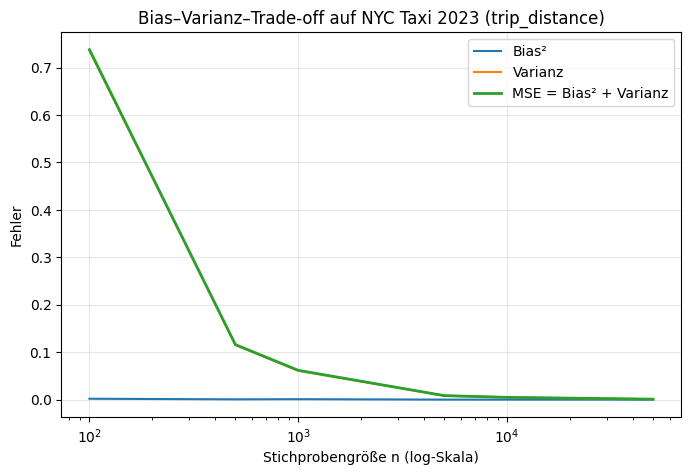

n=  100 | Bias^2=0.00187 | Var=0.736093 | MSE=0.73797
n=  500 | Bias^2=0.00059 | Var=0.115319 | MSE=0.11591
n= 1000 | Bias^2=0.00091 | Var=0.060880 | MSE=0.06179
n= 5000 | Bias^2=0.00004 | Var=0.008370 | MSE=0.00841
n=10000 | Bias^2=0.00002 | Var=0.004775 | MSE=0.00480
n=50000 | Bias^2=0.00001 | Var=0.000949 | MSE=0.00096


In [14]:
# 1) Daten aus deinem DF holen (NYC 2023)
x = df.loc[df.tpep_pickup_datetime.dt.year == 2023, "trip_distance"].to_numpy(dtype=np.float64, copy=False)
mu_true = x.mean()

# 2) Simulation über echte Daten
sample_sizes = [100, 500, 1000, 5000, 10000, 50000]
B = 100 # Wiederholungen pro n
rng = np.random.default_rng(0)

results = []
for n in sample_sizes:
    means = [rng.choice(x, size=n, replace=False).mean() for _ in range(B)]
    bias  = np.mean(means) - mu_true
    var   = np.var(means, ddof=1)
    mse   = bias**2 + var
    results.append((n, bias**2, var, mse))

# 3) Plot (Bias², Varianz, MSE) auf Basis DEINER Daten
n, bias2, var, mse = (np.array(col) for col in zip(*results))
plt.figure(figsize=(8,5))
plt.plot(n, bias2, label="Bias²")
plt.plot(n, var,   label="Varianz")
plt.plot(n, mse,   label="MSE = Bias² + Varianz", linewidth=2)
plt.xscale("log")
plt.xlabel("Stichprobengröße n (log-Skala)")
plt.ylabel("Fehler")
plt.title("Bias–Varianz–Trade-off auf NYC Taxi 2023 (trip_distance)")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# 4) Kompakte Tabelle
for n_i, b2, v, m in results:
    print(f"n={n_i:5d} | Bias^2={b2:.5f} | Var={v:.6f} | MSE={m:.5f}")

### Effizienz

In [15]:
n = 10_000
means = [rng.choice(x, size=n, replace=False).mean() for _ in range(100)]
medians = [np.median(rng.choice(x, size=n, replace=False)) for _ in range(100)]
print("Varianz Mittelwert:", np.var(means))
print("Varianz Median:", np.var(medians))

Varianz Mittelwert: 0.004360330786589996
Varianz Median: 0.0014260000000000028
